# Topic Subscriptions: Adoption Metrics Analysis

[Task](https://phabricator.wikimedia.org/T280896)

[Measurement plan](https://docs.google.com/document/d/15eD960rWRzxqYNQpjgsqd8nGwW9cRrpzOfYVd7nkX-0/edit#)

[Instrumentation spec](https://docs.google.com/spreadsheets/d/1wlGzy6oZ8jbY5-EpydN7SqZnG1ikHTk05ZsZx1euWME/edit)

# Purpose 

This task is about learning the extent to which contributors are engaging with the Topic Subscription beta feature (Manual and Automatic) and finding the feature valuable. Results of this analysis reflect how each feature has been used since deployed as a beta feature and will be used to decide whether Topic Subscriptions are in a state where the feature's impact can be evalauated through an AB test.


# Contents
1. [Are people aware of and trying the topic subscription feature?](#1.-Are-people-aware-of-and-trying-the-topic-subscription-feature?)
2. [Are people finding the topic subscription feature valuable?](#2.-Are-people-finding-the-topic-subscription-feature-valuable?)
3. [Are people finding the topic subscription feature disruptive?](#3.-Are-people-finding-the-topic-subscription-feature-disruptive?)

# Data Source and Timeline

**Sources**
The results below reflect data retreived from the following data sources.
* Discussiontools subscription [table](https://www.mediawiki.org/wiki/Extension:DiscussionTools/discussiontools_subscription_table). This provides a current snapshort of the users subscription status.
* [EchoInteraction](https://schema.wikimedia.org/repositories//secondary/jsonschema/analytics/legacy/echointeraction/current.yaml): Users interactions with the notifications (might not be needed for this analysis)
* [Echo_notification](https://www.mediawiki.org/wiki/Extension:Echo/echo_notification_table) database: Tracks notifications sent to users and if they received them.
* [Mediawiki-history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history): Tracks published edit events.

**Reviewed timelines**
For the purpose of this analysis we reviewed all events logged since on 19 October 2021 (deployment of the manual topic notification at all Wiki project[i]) for manual topic subscription and since 13 January 2022 (deployment of automatic topic notifications at most Wikis) through 1 March 2022.

[i] Note: For the purpose of this analysis, we only reviewed the timeframe once available at all wikis; however, manual topic subscriptions were rolled out to groups of wikis beginning on 28 June 2021.  Please see the topic notifications [project page](https://www.mediawiki.org/w/index.php?title=Talk_pages_project/Notifications&useskin=vector-2022) for further details about the deployment timeline for each feature.

# 1. Are people aware of and trying the topic subscription feature?

## Of the people who have published an unreverted talk page edit in the time since Topic Subscriptions became available (including posting new comments or sections or editing exiting comments), what percent have subscribed to at least one topic. 

**Notes**:
* We cannot know whether the topic someone subscribed to is a topic they also edited/contributed to.
* At this time of this report, we did not have February editing data available so we only reviewed talk page edits made since topic Subscriptions become available on all Wikis (19 October 2021) through the end of January 2022.

In [3]:
import pandas as pd
import numpy as np

import datetime as dt

from wmfdata import hive, mariadb

### All Talk Page Editors

We will first begin by finding all users that have published at least 1 unreverted talk page edit since topic Subscriptions become available on all Wikis (19 October 2021) through the end of January 2022.

In [264]:
HIVE_SNAPSHOT = "2022-01"
START_OF_DATA = "2021-10-19"
END_OF_DATA = "2022-01-30" #allow two days to avoid revert data censoring

In [265]:
# collect all talk page edits on desktop
talk_page_editor_query = """

SELECT
     wiki_db AS wiki,
     event_user_id AS user_id,
     CASE
        WHEN min(event_user_revision_count) < 100 THEN 'under 100'
        WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count <= 500)) THEN '100-500'
        ELSE 'over 500'
        END AS edit_count,
    COUNT(revision_id) as num_edits
FROM wmf.mediawiki_history 
WHERE 
    -- include only desktop edits
    NOT array_contains(revision_tags, 'iOS')
    AND NOT array_contains(revision_tags, 'Android')
    AND NOT array_contains(revision_tags, 'Mobile Web')
     -- find all edits on talk pages 
    AND page_namespace_historical % 2 = 1
    AND event_entity = 'revision'
    AND event_type = 'create'
-- edits not reverted within 48 hours
    AND NOT (revision_is_identity_reverted 
    AND revision_seconds_to_identity_revert <= 172800)
    -- remove bots
    AND size(event_user_is_bot_by) <= 0 
    AND size(event_user_is_bot_by_historical) <= 0 
    -- date deployed
    AND event_timestamp >= "{START_OF_DATA}"
    AND event_timestamp < "{END_OF_DATA}" 
     -- FROM THE LATEST SNAPSHOT
    AND snapshot = "{hive_snapshot}" 
    -- user is not anonymous
    AND event_user_is_anonymous = FALSE
GROUP BY 
 wiki_db,
 event_user_id
 """

In [266]:
talk_page_editors = hive.run(
    talk_page_editor_query.format(
        hive_snapshot = HIVE_SNAPSHOT,
        START_OF_DATA= START_OF_DATA,
        END_OF_DATA=END_OF_DATA
    )
)

In [267]:
Total_talk_page_ed = talk_page_editors['user_id'].count()
print('Total number of editors for whom we will be checking topic subscription status:' , Total_talk_page_ed) 

Total number of editors for whom we will be checking topic subscription status: 163085


We will be using the discussiontools_subscription table to identify talk page editors that have enabled a subscription. Note that if a user has not subscribed to a topic then there will be no record for that user in this table.

In [268]:
#Querying discussiontools_subscription to see if any of the users have subscribed to a topic subscription

query='''
SELECT 
    database() AS wiki,
    sub_user AS topic_subscriber,
    COUNT(*) As num_subscriptions
FROM discussiontools_subscription
WHERE sub_user in ({users})
GROUP BY
    database(),
    sub_user
'''

In [269]:
# Looping through each wiki for the list of users 

wikis=talk_page_editors['wiki'].unique()
topic_subscription=list()
for wiki in wikis:
    user_ids = talk_page_editors[talk_page_editors['wiki'] == wiki]["user_id"]
    user_list = ','.join([str(u) for u in user_ids])
    sub_status = mariadb.run(
      query.format(users=user_list),
      wiki
    )
    topic_subscription.append(sub_status)

topic_subscription_status= pd.concat(topic_subscription)

In [270]:
# Total number of distinct topic subscribers
topic_users = topic_subscription_status['topic_subscriber'].nunique()
print('Total number of talk page editors that have subscribed to at least 1 topic since enabled' , topic_users) 

Total number of talk page editors that have subscribed to at least 1 topic since enabled 2743


1.7% of all users that have made at least unreverted edit to a talk page since 19 October 2021 have subscribed to at least one new topic (as of the time of this report). This lower percentage is expected as the feature is currently only available as a beta preference. 

Now we join the topic subscribers data with the talk page editors data for further analysis and breakdowns.

In [271]:
# join two dataframes
talk_page_subscribers = talk_page_editors.merge(topic_subscription_status, 
                                               how = "left", left_on = ["user_id", "wiki"] , 
                                               right_on = ["topic_subscriber", "wiki"])

In [272]:
#refill missing columns with string types to avoid type errors
talk_page_subscribers['topic_subscriber'] = talk_page_subscribers['topic_subscriber'].astype(str)
talk_page_subscribers['num_subscriptions'] = talk_page_subscribers['num_subscriptions'].astype(str)

#### By Experience Group

In [24]:
%load_ext rpy2.ipython

/home/mneisler/.conda/envs/2021-01-13T22.04.48_mneisler/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [25]:
%%R
# load required R packages
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate); library(scales)
})

In [274]:
%%R -i talk_page_subscribers
# import df from global environment

NULL


In [275]:
%%R
talk_page_subscribers_byexp <- talk_page_subscribers %>%
    group_by(edit_count) %>%
    summarise(num_talk_editors = n(),
             num_topic_subscribers = sum(topic_subscriber != "nan"),
             pct_subscribed = num_topic_subscribers/num_talk_editors * 100)

talk_page_subscribers_byexp

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 3 x 4
  edit_count num_talk_editors num_topic_subscribers pct_subscribed
  <chr>                 <int>                 <int>          <dbl>
1 100-500               15157                   223          1.47 
2 over 500              42774                  2082          4.87 
3 under 100            105154                   441          0.419


When broken down by experience group, the majority of talk page editors that have subscribed to a topic are senior editors (defined as having over 500 edits). 4.9% of all senior talk page editors have subscribed to a topic. 

### Talk page editors that have enabled topic subscription preference enabled

Next we'll look specifically at talk page editors that have enabled the beta preference to see if they are using it. 

Note: we reviewed users that enabled `discussiontools-betaenable` as an indicator if they have the topic subscriptions feature enabled.  The `discussiontools-topicsub` preference is enabled by default when the beta preference is enabled.

In [276]:
#Querying the user_properties table to find talk page editors that have enabled the beta feature

query='''
 SELECT
    DISTINCT up_user AS beta_user,
    database() AS wiki,
    up_value AS pref_status
FROM user_properties
    WHERE 
    up_user in ({users})
    AND up_property = 'discussiontools-betaenable'
    
 '''


In [277]:
# Looping through each wiki for the list of talk page editors that have the beta preference enabled 

wikis=talk_page_editors['wiki'].unique()
beta_enabled=list()
for wiki in wikis:
    user_ids = talk_page_editors[talk_page_editors['wiki'] == wiki]["user_id"]
    user_list = ','.join([str(u) for u in user_ids])
    beta_status = mariadb.run(
      query.format(users=user_list),
      wiki
    )
    beta_enabled.append(beta_status)

beta_enabled_status= pd.concat(beta_enabled)

In [278]:
# replace skin field as string type for easier renaming 
beta_enabled_status['pref_status'] = beta_enabled_status['pref_status'].astype(str)


In [279]:
# rename pref values to clarify
pref_aliases = {
    "b\'0\'":"disabled",
    "b\'1\'":"enabled",
}

beta_enabled_status = beta_enabled_status.replace({"pref_status": pref_aliases})

In [280]:
# Total number of distinct topic users that have the feature enabled
beta_users = beta_enabled_status[beta_enabled_status.pref_status == "enabled"]
beta_users_total = beta_users['beta_user'].nunique()

In [281]:
print('Total number of talk page editors that have the discussion tools beta feature enabled' , beta_users_total) 

Total number of talk page editors that have the discussion tools beta feature enabled 9777


A total of 9,777 distinct talk page editors have the discussion tools beta feature currently enabled. Of these users, 28% have subscribed to at least 1 topic.

In [282]:
# join two dataframes
talk_page_subscribers_wbeta = talk_page_subscribers.merge(beta_users, 
                                               how = "left", left_on = ["user_id", "wiki"] , 
                                               right_on = ["beta_user", "wiki"])

In [283]:
#refill missing columns with string types to avoid type errors
talk_page_subscribers_wbeta['beta_user'] = talk_page_subscribers_wbeta['beta_user'].astype(str)
talk_page_subscribers_wbeta['pref_status'] = talk_page_subscribers_wbeta['pref_status'].astype(str)

#### By Experience Group

In [285]:
%%R -i talk_page_subscribers_wbeta
# import df from global environment

# breakdown by experience
talk_page_subscribers_wbeta_byexp <- talk_page_subscribers_wbeta %>%
    group_by(edit_count) %>%
    summarise(num_talk_editors = n(),
              num_beta_users = sum(beta_user != "nan"),
             num_topic_subscribers = sum(topic_subscriber != "nan"),
             pct_beta_subscribed = num_topic_subscribers/num_beta_users * 100)

talk_page_subscribers_wbeta_byexp

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 3 x 5
  edit_count num_talk_editors num_beta_users num_topic_subscri… pct_beta_subscr…
  <chr>                 <int>          <int>              <int>            <dbl>
1 100-500               15157           1349                223             16.5
2 over 500              42774           5247               2082             39.7
3 under 100            105154           3219                441             13.7


About 39% of Senior Contributors that have enabled the beta feature and edited a talk page have subscribed to at least 1 topic.

# 2. Are people finding the topic subscription feature valuable?

## [Manual] Of the people who have topic subscriptions enabled, what percentage of people are actively subscribed to the following number of discussions?

Notes:
* We reviewed the percent of people that not just have topic subscriptions preference enabled but have subscribed to at least 1 topic so you can get a sense of how frequently the feature is used by people that subscribe to at least 1 subscription. The prior section answers the question about how many users that have enabled the topic preference have subscribed to at least 1 topic.
* The manual topic subscription preference is turned on by default when a user enables the Discussion Tools beta property. It does not need to be explicitly turned on in Special:Preferences. As a result, this property will not appear in the user properties table unless it is turned off. 

In [286]:
#loop through all wiki projects to create list of wikis for use in queries

query = """ 
    SELECT
        DISTINCT database_code
    FROM canonical_data.wikis
    WHERE
    database_code NOT IN ('labswiki', 'labtestwiki', 'legalteamwiki')
   """

In [287]:
wikis = hive.run(query)

In [288]:
wiki_list=wikis['database_code'].unique()

In [289]:
#Querying discussiontools_subscription to determine subscription status

query='''
SELECT 
    database() AS wiki,
    sub_user AS topic_subscriber,
     CASE 
            WHEN sub_state = 1 THEN 'manual'
            WHEN sub_state = 2 THEN 'automatic'
            WHEN sub_state = 0 THEN 'unsubscribed'
            ELSE 'NULL'
            END AS initiation_type,
        CASE 
            WHEN (sub_state = 1 OR sub_state = 2) THEN 'active'
            ELSE 'inactive'
            END AS sub_status,
    COUNT(*) As num_subscriptions
FROM discussiontools_subscription
GROUP BY
    database(),
    sub_user
'''

In [290]:
topic_subscriptions = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

Next we find all users that have the manual topic subscription enabled.

In [291]:
#Querying the user_properties table  to find all users that have enabled the beta feature
## And have not disabled the topic subscription feature 

query='''
-- users that have not disabled the property
WITH topic_pref AS (
 SELECT
    up_user AS topic_user,
    database() AS wiki
FROM user_properties
WHERE 
--if disabled this property will appear in user properties as it is the non-default option
    NOT up_property = 'discussiontools-topicsubscription'
),

beta_pref AS (
 SELECT
    up_user AS beta_user,
    database() AS wiki,
    up_value AS pref_status
FROM user_properties
    WHERE 
    up_property = 'discussiontools-betaenable'
)

SELECT
    beta_user,
    beta_pref.wiki,
    pref_status
FROM beta_pref
INNER JOIN topic_pref ON
beta_pref.beta_user = topic_pref.topic_user
AND beta_pref.wiki = topic_pref.wiki
 '''

In [294]:
# # ALternative if query above not working
## Does not account for any users that explciitly disabled the manual topic subscription preference but that is a small percent
# query='''
# SELECT
#     up_user AS beta_user,
#     database() AS wiki,
#     up_value AS pref_status
# FROM user_properties
#     WHERE 
#     up_property = 'discussiontools-betaenable'
# '''

In [295]:
manual_pref = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [296]:
# replace skin field as string type for easier renaming 
manual_pref['pref_status'] = manual_pref['pref_status'].astype(str)

In [297]:
# rename pref values to clarify
pref_aliases = {
    "b\'0\'":"disabled",
    "b\'1\'":"enabled",
}

manual_pref = manual_pref.replace({"pref_status": pref_aliases})

In [299]:
# Total number of distinct users that have the feature enabled
manual_pref_enabled = manual_pref[manual_pref.pref_status == "enabled"]
manual_pref_enabled_total = manual_pref_enabled['beta_user'].nunique()   

manual_pref_enabled_total

94890

There are 94,890 users that have the manual topic subscription feature enabled currently in there user preferences (this includes users that might not have edited a talk page since the feature was deployed). Next, we'll determine what percent of these users are actively subscribed to at least one subscription. 

In [300]:
# join two dataframes
manual_users_sub_status = manual_pref_enabled.merge(topic_subscriptions, 
                                               how = "left", left_on = ["beta_user", "wiki"] , 
                                               right_on = ["topic_subscriber", "wiki"])

In [301]:
#refill missing columns with string types to avoid type errors
manual_users_sub_status['topic_subscriber'] = manual_users_sub_status['topic_subscriber'].astype(str)
manual_users_sub_status['initiation_type'] = manual_users_sub_status['initiation_type'].astype(str)
manual_users_sub_status['sub_status'] = manual_users_sub_status['sub_status'].astype(str)
manual_users_sub_status['num_subscriptions'] = manual_users_sub_status['num_subscriptions'].astype(str)

In [302]:
%%R  -i manual_users_sub_status
# import df from global environment

NULL


In [303]:
%%R
# Find percent oveall 
active_manual_subscribers <- manual_users_sub_status %>%
    summarise(num_beta_users = n(),
              num_beta_users_check = n_distinct(beta_user),
             num_manual_subscribers = length(topic_subscriber[initiation_type == 'manual']),
             pct_beta_manual = num_manual_subscribers/num_beta_users * 100)

active_manual_subscribers

  num_beta_users num_beta_users_check num_manual_subscribers pct_beta_manual
1          96485                94890                   2064        2.139193


2.1% of all users subscribed to manual topic subscriptions are actively manually subscribed to at least one topic discussion.  Note: This is not restricted to users that have edited a talk page so many of these users may not have visited a talk page since it become availabe as the manual preference is enabled by default for discussion tool beta users.


### Breakdown by the number of subscriptions

We next reviewed the percent of users that have at least 1 manual active subscription enabled by number of active subscriptions. 

Notes:
* Based on review of the average number of active subscriptions per user, I decided to group the number of subscriptions by 2. Since the majority of user subscribe to only 1 or 2 topic subscriptions, these smaller groupings provide the level of detail needed to understand the frequency of usage.

In [304]:
%%R 
# percent of users by num of subscriptions group 
active_manual_subscriptions <- manual_users_sub_status %>%
    filter(pref_status == 'enabled' & # only users that have the prefernece enabled and 1 active subscription
          initiation_type == 'manual')  %>%
    mutate(num_subscriptions_group = cut(as.numeric(num_subscriptions), 
                                         breaks = c(0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, Inf), 
                                         labels = c('1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14',
                                                    '15-16', '17-18', '19-20','over 20')))  %>%
    group_by(num_subscriptions_group) %>%
    summarise(n_users = n_distinct(topic_subscriber))%>%
    mutate(percent_users = n_users/sum(n_users))
    

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



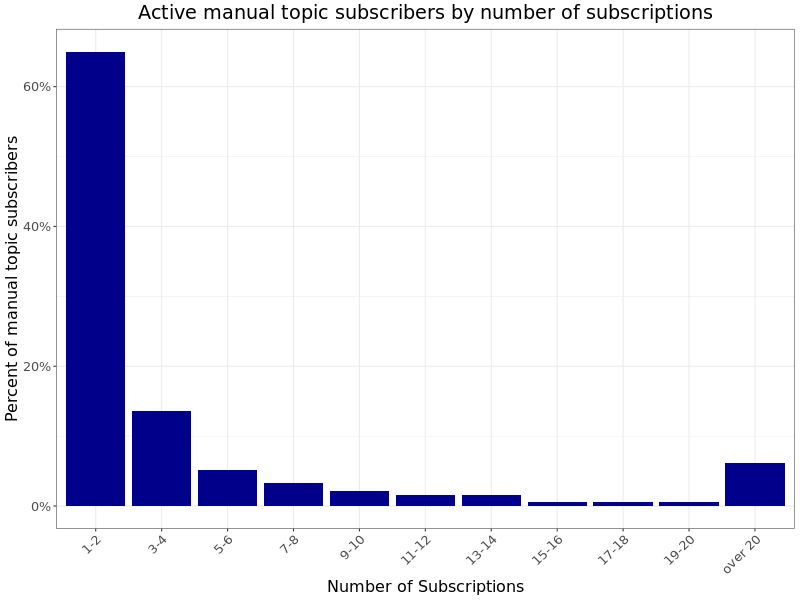

In [305]:
%%R -w 800 -h 600
#chart overall users by days of activity group

p <- active_manual_subscriptions %>%
    ggplot(aes(x=num_subscriptions_group, y = percent_users)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of manual topic subscribers",
          x = "Number of Subscriptions",
         title = "Active manual topic subscribers by number of subscriptions")  +
     theme_bw() +
   theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none") 

ggsave("Figures/active_manual_subscribers_bynsub.png", p, width = 16, height = 8, units = "in", dpi = 300)
p

The majority (65%) users actively subscribed to manual topic subscriptions are subscribed to 1 to 2 topics. 35% of manual topic subscribers have subscribed to over 2 distinct topics. 

Note: 1% of these users are subscribed to over 1000 manual topic subscriptions. Reasons for these outliers? Could this be bot related?

## [Automatic] Of the people who have manual topic subscriptions enabled (and edited a talk page[ii]), what percentage of them enabled automatic topic subscriptions within Special:Preferences?

Automatic Topic Subscriptions are available as a beta feature at most Wikimedia wikis as of 13 January 2022 [iii].  For people to become automatically subscribed to discussions they start and/or comment within, they will need to manually enable the Automatically subscribe to topics setting within Special:Preferences#mw-prefsection-editing.

We will look at the percent of people who have the manual topic subscription feature enabled and have also explcitly enabled this feature. 

Note:
* [ii] Since the manual topic subscription feature is enabled by default, we will look only at users that edited a talk page to look specifically at users that have visited talk pages since deployment of automatic topic feature been availble. Alternate option for consideration: Review users that are manaully subscribed to a topic.
* [iii] See https://phabricator.wikimedia.org/T290500?useskin=vector-2022 for list of wikis where automatic topic subscriptions are not currently offered as a beta feature.
* For this analysis, we reviewed from the time automatic topic subscriptions become available on 13 January 2022 to 2 March 2022.
* The automatic topic subscription preference 'discussiontools-autotopicsub' will appears in the user properties table when explicitly enabled. It is not enabled by default with the discussion tools beta preference.

In [306]:
#Querying the user_properties table to find beta users that have enabled the automatic topic preference setting

query='''
-- users that enabled the beta property and therfore the manual topic subscription property
WITH dt_users AS (
 SELECT
    DISTINCT up_user AS beta_user,
    database() AS wiki,
    up_value AS beta_status
FROM 
    user_properties
WHERE 
    up_property = 'discussiontools-betaenable'
),
-- users that enabled the auto topic subsctiption
auto_users AS (
SELECT
    DISTINCT up_user AS auto_user,
    database() AS wiki,
    up_value AS auto_status
FROM user_properties
WHERE
  up_property = 'discussiontools-autotopicsub'
  )

SELECT
 beta_user,
 beta_status,
 auto_user,
 auto_status,
 dt_users.wiki
FROM
    dt_users
LEFT JOIN 
    auto_users ON
    dt_users.beta_user = auto_users.auto_user AND
    dt_users.wiki = auto_users.wiki
    
 '''

In [307]:
auto_users = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [308]:
# replace skin field as string type for easier renaming 
auto_users['beta_status'] = auto_users['beta_status'].astype(str)
auto_users['auto_status'] = auto_users['auto_status'].astype(str)

In [309]:
# rename pref values to clarify
pref_aliases = {
    "b\'0\'":"disabled",
    "b\'1\'":"enabled",
}

auto_users =auto_users.replace({"beta_status": pref_aliases})
auto_users =auto_users.replace({"auto_status": pref_aliases})

In [310]:
#refill missing columns with string types to avoid type errors
auto_users['auto_user'] = auto_users['auto_user'].astype(str)
auto_users['auto_status'] = auto_users['auto_status'].astype(str)

In [312]:
%%R  -i auto_users
#import from global environment

NULL


In [314]:
%%R
auto_users_pct <- auto_users %>%
      filter(beta_status == 'enabled', # only users that have manual preference enabled
             !(wiki %in% c('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki',
                         'frwiki', 'hewiki', 'hiwiki', 'idwiki', 'itwiki', 'jawiki',
                         'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki',
                         'thwiki', 'ukwiki', 'viwiki'))) %>% #remove wikis where not available
      summarise(num_beta_users = n(),
            num_auto_subscribers = length(auto_user[auto_status == 'enabled']),
             pct_auto_users = num_auto_subscribers/num_beta_users * 100)
    
auto_users_pct 


  num_beta_users num_auto_subscribers pct_auto_users
1          68010                  537      0.7895898


There are 537 users that have enabled the automatic topic subscriptions preference across all wikis where available. This represents about 0.8% of all users that have manual topic subscriptions enabled. This percentage may be small because many of the users that have the beta preference enabled may not have viewed a talk page since it has only be enabled for a month. 

We next reviewed the percent of users that edits a talk page since automatic preference was made available to get a better estimate of the percent of users that had access to the feature and enabled it. 

### Of the users that have edited a talk page since it was deployed, what percent of beta users have also enabled the automatic topic subscription preference?


In [315]:
HIVE_SNAPSHOT = "2022-01"
START_OF_DATA = "2022-01-13"
END_OF_DATA = "2022-01-30" #allow two days to avoid revert data censoring

In [316]:
# collect all talk page edits on desktop
talk_page_editor_query = """

SELECT
     wiki_db AS wiki,
     event_user_id AS user_id,
     CASE
        WHEN min(event_user_revision_count) < 100 THEN 'under 100'
        WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count <= 500)) THEN '100-500'
        ELSE 'over 500'
        END AS edit_count,
    COUNT(revision_id) as num_edits
FROM wmf.mediawiki_history 
WHERE 
    -- include only desktop edits
    NOT array_contains(revision_tags, 'iOS')
    AND NOT array_contains(revision_tags, 'Android')
    AND NOT array_contains(revision_tags, 'Mobile Web')
     -- find all edits on talk pages 
    AND page_namespace_historical % 2 = 1
    AND event_entity = 'revision'
    AND event_type = 'create'
-- edits not reverted within 48 hours
    AND NOT (revision_is_identity_reverted 
    AND revision_seconds_to_identity_revert <= 172800)
    -- remove bots
    AND size(event_user_is_bot_by) <= 0 
    AND size(event_user_is_bot_by_historical) <= 0 
    -- date deployed
    AND event_timestamp >= "{START_OF_DATA}"
    AND event_timestamp < "{END_OF_DATA}" 
     -- FROM THE LATEST SNAPSHOT
    AND snapshot = "{hive_snapshot}" 
    -- user is not anonymous
    AND event_user_is_anonymous = FALSE
    -- remove wikis where not available
    AND wiki_db NOT IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki',
                         'frwiki', 'hewiki', 'hiwiki', 'idwiki', 'itwiki', 'jawiki',
                         'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki',
                         'thwiki', 'ukwiki', 'viwiki')
GROUP BY 
 wiki_db,
 event_user_id
 """

In [317]:
talk_page_editors_auto_deployment = hive.run(
    talk_page_editor_query.format(
        hive_snapshot = HIVE_SNAPSHOT,
        START_OF_DATA= START_OF_DATA,
        END_OF_DATA=END_OF_DATA
    )
)

In [318]:
Total_talk_page_editors_auto_deployment = talk_page_editors_auto_deployment['user_id'].count()
print('Total number of users that have edited a talk page since automatic topic subscription preference became available:' , Total_talk_page_editors_auto_deployment) 

Total number of users that have edited a talk page since automatic topic subscription preference became available: 36192


In [319]:
#Querying the user_properties table to find beta users that have enabled the automatic topic preference setting

query='''
WITH dt_users AS (
 SELECT
    DISTINCT up_user AS beta_user,
    database() AS wiki,
    up_value AS beta_status
FROM 
    user_properties
WHERE 
    up_property = 'discussiontools-betaenable'
),

auto_users AS (
SELECT
    DISTINCT up_user AS auto_user,
    database() AS wiki,
    up_value AS auto_status
FROM user_properties
WHERE
  up_property = 'discussiontools-autotopicsub'
  )

SELECT
 beta_user,
 beta_status,
 auto_user,
 auto_status,
 dt_users.wiki
FROM
    dt_users
LEFT JOIN 
    auto_users ON
    dt_users.beta_user = auto_users.auto_user AND
    dt_users.wiki = auto_users.wiki
WHERE beta_user in ({users})
    
 '''

In [320]:
# Looping through each wiki for the list of users 

wikis=talk_page_editors_auto_deployment['wiki'].unique()
auto_preference=list()
for wiki in wikis:
    user_ids = talk_page_editors_auto_deployment[talk_page_editors_auto_deployment['wiki'] == wiki]["user_id"]
    user_list = ','.join([str(u) for u in user_ids])
    auto_status = mariadb.run(
      query.format(users=user_list),
      wiki
    )
    auto_preference.append(auto_status)

talk_user_auto_preference_status= pd.concat(auto_preference)

In [322]:
# replace skin field as string type for easier renaming 
talk_user_auto_preference_status['beta_status'] = talk_user_auto_preference_status['beta_status'].astype(str)
talk_user_auto_preference_status['auto_status'] = talk_user_auto_preference_status['auto_status'].astype(str)

In [323]:
# rename pref values to clarify
pref_aliases = {
    "b\'0\'":"disabled",
    "b\'1\'":"enabled",
}

talk_user_auto_preference_status =talk_user_auto_preference_status.replace({"beta_status": pref_aliases})
talk_user_auto_preference_status =talk_user_auto_preference_status.replace({"auto_status": pref_aliases})

In [324]:
#refill missing columns with string types to avoid type errors
talk_user_auto_preference_status['auto_user'] = talk_user_auto_preference_status['auto_user'].astype(str)
talk_user_auto_preference_status['auto_status'] = talk_user_auto_preference_status['auto_status'].astype(str)

In [325]:
%%R  -i talk_user_auto_preference_status
#import from global environment

NULL


In [327]:
%%R
talk_user_auto_pref_pct <- talk_user_auto_preference_status %>%
      filter(beta_status == 'enabled') %>% 
      summarise(num_beta_users = n(),
                num_auto_subscribers =  sum(auto_user != "nan"),
             pct_auto_users = num_auto_subscribers/num_beta_users * 100)
    
talk_user_auto_pref_pct 


  num_beta_users num_auto_subscribers pct_auto_users
1           3076                  187       6.079324


### By Experience Group

In [328]:
# join two dataframes
talk_page_auto_pref_witheditcount = talk_page_editors_auto_deployment.merge(talk_user_auto_preference_status, 
                                               how = "left", left_on = ["user_id", "wiki"] , 
                                               right_on = ["beta_user", "wiki"])

In [330]:
#refill missing columns with string types to avoid type errors
talk_page_auto_pref_witheditcount['beta_user'] = talk_page_auto_pref_witheditcount['beta_user'].astype(str)
talk_page_auto_pref_witheditcount['beta_status'] = talk_page_auto_pref_witheditcount['beta_status'].astype(str)
talk_page_auto_pref_witheditcount['auto_user'] = talk_page_auto_pref_witheditcount['auto_user'].astype(str)
talk_page_auto_pref_witheditcount['auto_status'] = talk_page_auto_pref_witheditcount['auto_status'].astype(str)

In [332]:
%%R -i talk_page_auto_pref_witheditcount
# import df from global environment

# breakdown by experience
talk_page_auto_pref_witheditcount_sum <- talk_page_auto_pref_witheditcount %>%
    group_by(edit_count) %>%
    summarise(num_talk_editors = n(),
              num_beta_users = sum(beta_status == "enabled"),
             num_auto_subscribers = sum(auto_status == "enabled"),
             pct_beta_subscribed = num_auto_subscribers/num_beta_users * 100)

talk_page_auto_pref_witheditcount_sum

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 3 x 5
  edit_count num_talk_editors num_beta_users num_auto_subscrib… pct_beta_subscr…
  <chr>                 <int>          <int>              <int>            <dbl>
1 100-500                3452            383                 13             3.39
2 over 500              15482           2190                141             6.44
3 under 100             17258            503                 33             6.56


## [Both] Percentage of new comment notifications Junior and Senior Contributors engage with (e.g. make as read, tap a notification) within two weeks of receiving them.

**Data Source**: 
* [echo_notification table](https://www.mediawiki.org/wiki/Extension:Echo/echo_notification_table?useskin=vector-2022)
* [Echo Interfaction](https://schema.wikimedia.org/repositories//secondary/jsonschema/analytics/legacy/echointeraction/current.yaml)

Notes: 
* With currently available instrumentation, we do not know the type of notification that was sent and read. As a result, I limited this analysis to contributors that have subscribed to a topic (either automatic or manual). Note: This may still include some notifications received by topic subscribers that were not sent from the topic notifications feature.
* TODO: Will submit a ticket to add a notification type field to Echo Interaction so we can more clearly identify events sent by this feature.

We first find all notifications 

In [334]:
query = '''
SELECT
DATEDIFF(notification_read_timestamp, notification_timestamp) AS diff_days
FROM
echo_notification
WHERE 
notification_timestamp >= 20211019000000
'''


In [335]:
notifications = mariadb.run(commands = query, dbs = wiki_list, use_x1=True, format="pandas")

In [338]:
%%R -i notifications
# import from global environment

NULL


In [339]:
%%R
notification_engagement <- notifications %>%
   mutate(time_to_engage = 
          ifelse(diff_days <= 14, "within_2_weeks", "over_2_weeks")) %>%
    group_by(time_to_engage)  %>%
    summarise(n = n()) %>%
    mutate(Freq = n/sum(n) * 100)
    

notification_engagement

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 3 x 3
  time_to_engage       n  Freq
  <chr>            <int> <dbl>
1 over_2_weeks    261890  2.46
2 within_2_weeks 4056886 38.2 
3 <NA>           6311829 59.4 


38% of all notifications were sent following deployment of the manual topic subscriptions features were read within two weeks. A large percentage of notifications are not read; however, the results are not currently limited to just notifications sent with manual or automatic topic subscriptions. 

We'll next take a look at only users that are subscribed to a manual or automatic topic subscription.

In [340]:
#Querying discussiontools_subscription to find all topic subscibers

query='''
SELECT 
    database() AS wiki,
    sub_user AS topic_subscriber,
    COUNT(*) AS num_subscriptions
FROM discussiontools_subscription
GROUP BY
    database(),
    sub_user
'''

In [341]:
active_subscribers = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [342]:
#find all time to read for all notifications sent to users that are actively subscribed to a topic
query = '''
SELECT
DATEDIFF(notification_read_timestamp, notification_timestamp) AS diff_days
FROM
echo_notification
WHERE 
notification_user in ({users}) AND
notification_timestamp >= 20211019000000
'''




In [343]:
# Looping through each wiki for the list of users 

wikis=active_subscribers['wiki'].unique()
active_subscribers_notification=list()
for wiki in wikis:
    user_ids = active_subscribers[active_subscribers['wiki'] == wiki]["topic_subscriber"]
    user_list = ','.join([str(u) for u in user_ids])
    notification_status = mariadb.run(
      query.format(users=user_list),
      wiki,
      use_x1 = True
    )
    active_subscribers_notification.append(notification_status)

active_subscribers_notification_status= pd.concat(active_subscribers_notification)

In [344]:
%%R -i active_subscribers_notification_status
# import from global environment

NULL


In [345]:
%%R
notification_engagement_subscribers <- active_subscribers_notification_status %>%
   mutate(time_to_engage = 
          ifelse(diff_days <= 14, "within_2_weeks", "over_2_weeks")) %>%
    group_by(time_to_engage)  %>%
    summarise(n = n()) %>%
    mutate(Freq = n/sum(n) * 100)
    

notification_engagement_subscribers

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 3 x 3
  time_to_engage      n  Freq
  <chr>           <int> <dbl>
1 over_2_weeks    10466  2.34
2 within_2_weeks 414061 92.5 
3 <NA>            23249  5.19


Most notifications (92.5%) sent to topic subscribers (includes both manual or automatic topic subscribers) are read a notification within 2 weeks of recieving them.  

# 3. Are people finding the topic subscription feature disruptive?

## [Automatic] Of the people who enabled Automatic Topic Subscriptions, what percentage of people disable the feature after have been automatically subscribed to at least one conversation?

Notes: 
* If a user disables the `discussiontools-autotopicsub` user property, it will disappear from their user preferences so we will need to check the absence of that property to confirm if it was disabled.
* To calculate this metric, we first determined all users that have been automatically subscribed to a topic subscription (implying that they turned the preference on) and then reviewed the number of those users that disabled that property.


In [346]:
#Querying discussiontools_subscription to determine users with automatic topic subscription 

query='''
SELECT 
    database() AS wiki,
    sub_user AS topic_subscriber,
    COUNT(*) As num_subscriptions
FROM discussiontools_subscription
WHERE 
-- automatic topic subscriptions
    sub_state = 2
GROUP BY
    database(),
    sub_user
'''

In [347]:
auto_topic_users = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [348]:
Total_auto_topic_users= auto_topic_users['topic_subscriber'].count()
print('Total number of subscribers for whom we will be checking auto topic subscription status:' , Total_auto_topic_users) 

Total number of subscribers for whom we will be checking auto topic subscription status: 259


There are 259 distinct users that are automatically subscribed to a topic notification.  Now we will check if any of those users do not have the 'discussiontools-autotopicsub' property set in their preferences indicating that they explicitly disabled the preference.

In [349]:
#Querying the user_properties table  to find past auto subscribers that have the feature still in their preferences

query='''
 SELECT
    DISTINCT up_user AS auto_user,
    up_value AS auto_status,
    database() AS wiki
FROM user_properties
    WHERE 
    up_property = 'discussiontools-autotopicsub'   
 '''

In [350]:
auto_topic_subscribers = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [353]:
# join two dataframes
auto_topic_subscribers_disabled = auto_topic_users.merge(auto_topic_subscribers, 
                                               how = "left", left_on = ["topic_subscriber", "wiki"] , 
                                               right_on = ["auto_user", "wiki"])

In [355]:
#refill missing columns with string types to avoid type errors
auto_topic_subscribers_disabled['auto_user'] = auto_topic_subscribers_disabled['auto_user'].astype(str)
auto_topic_subscribers_disabled['auto_status'] = auto_topic_subscribers_disabled['auto_status'].astype(str)

In [356]:
%%R -i auto_topic_subscribers_disabled
# import from global environment

NULL


In [358]:
%%R
auto_topic_subscribers_disabled_pct <- auto_topic_subscribers_disabled %>%
    summarise(auto_subscribers = n(),
             auto_disabled = sum(auto_user == "nan"),
              pct_disabled = auto_disabled/auto_subscribers * 100)

auto_topic_subscribers_disabled_pct

  auto_subscribers auto_disabled pct_disabled
1              259            61     23.55212


23% of users disabled the automatic topic subscription preference in their user properties after being automatically subscribed to a topic. 

## [Both] Sudden increase in the average number of notifications sent per person, per day.

**Data Source**: [echo_notification table](https://www.mediawiki.org/wiki/Extension:Echo/echo_notification_table?useskin=vector-2022)


In [201]:
query = '''
SELECT
notification_user,
notification_timestamp AS time_sent,
COUNT(notification_event) AS num_notifications
FROM
echo_notification
WHERE 
-- review several months before and after deployment
notification_timestamp >= 20210801000000
GROUP BY
notification_user,
notification_timestamp
'''

In [202]:
notifications_sent = mariadb.run(commands = query, dbs = wiki_list, use_x1=True, format="pandas")

In [203]:
%%R -i notifications_sent
# import from global environment

NULL


In [204]:
%%R
# convert time sent to date time
notifications_sent$time_sent <- as.Date(notifications_sent$time_sent, format = "%Y%m%d%H%M%S")

In [205]:
%%R
# calculate avg notifications sent per user per day
notifications_sent_byday <- notifications_sent %>%
    group_by(notification_user, time_sent) %>%
    summarise(n_notifications = sum(num_notifications)) %>%
    group_by(time_sent)  %>%
    summarise(avg_daily_notifications = mean(n_notifications))
 
    
head(notifications_sent_byday)

R[write to console]: `summarise()` regrouping output by 'notification_user' (override with `.groups` argument)

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 6 x 2
  time_sent  avg_daily_notifications
  <date>                       <dbl>
1 2021-08-01                    2.02
2 2021-08-02                    2.06
3 2021-08-03                    1.95
4 2021-08-04                    2.22
5 2021-08-05                    1.90
6 2021-08-06                    2.15


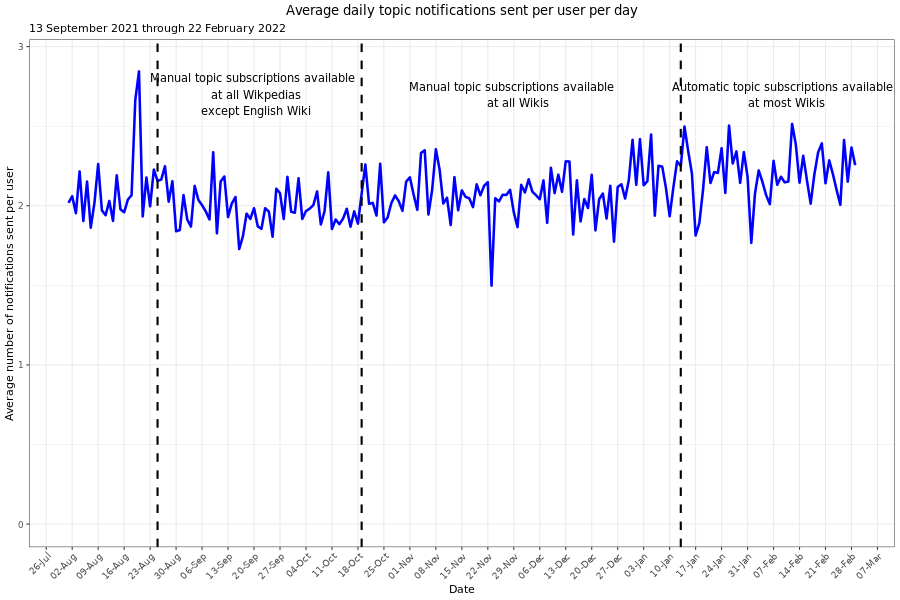

In [223]:
%%R -w 900 -h 600
# plot average notifications

textaes <- data.frame(y = c(2.7,2.7, 2.7),
                      x = as.Date(c('2021-09-20','2021-11-29','2022-02-10')),
                      lab = c("Manual topic subscriptions available \n  at all Wikpedias \n except English Wiki",
                          "Manual topic subscriptions available \n  at all Wikis", 
                              "Automatic topic subscriptions available \n at most Wikis"))

 p <- notifications_sent_byday %>%   
    ggplot(aes(x= time_sent, y = avg_daily_notifications)) +
    geom_line(size = 1.2, color = 'blue') +
    geom_vline(xintercept = as.Date('2021-08-25'), linetype = 'dashed', size = 1) +
    geom_vline(xintercept = as.Date('2021-10-19'), linetype = 'dashed', size = 1) +
    geom_vline(xintercept = as.Date('2022-01-13'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 4) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Average number of notifications sent per user",
          x = "Date",
         title = "Average daily topic notifications sent per user per day",
         subtitle = "13 September 2021 through 2 March 2022")  +
    ylim(0,2.9)+
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

ggsave("Figures/avg_daily_topic_notifications.png", p, width = 16, height = 8, units = "in", dpi = 300)
p

In [213]:
%%R
summary(notifications_sent_byday)

   time_sent          avg_daily_notifications
 Min.   :2021-08-01   Min.   :1.498          
 1st Qu.:2021-09-23   1st Qu.:1.965          
 Median :2021-11-15   Median :2.077          
 Mean   :2021-11-15   Mean   :2.088          
 3rd Qu.:2022-01-07   3rd Qu.:2.182          
 Max.   :2022-03-01   Max.   :2.844          


The average number of notifications sent per day has remained stable with the highest daily average of 2.8 notifications per user on 20 August 2021 (two days after manual topic notifications was deployed to Commons and Wikidata) and the lowest daily average of 1.5 notifications per user on 23 November 2021 (several weeks after manual topic notifications were available at all Wikis).


In [212]:
%%R
# total notifications
notifications_sent_byday_total <- notifications_sent %>%
    group_by(notification_user, time_sent) %>%
    summarise(n_notifications = sum(num_notifications))
    
summary(notifications_sent_byday_total)

R[write to console]: `summarise()` regrouping output by 'notification_user' (override with `.groups` argument)



 notification_user    time_sent          n_notifications   
 Min.   :       1   Min.   :2021-08-01   Min.   :   1.000  
 1st Qu.:  571354   1st Qu.:2021-09-22   1st Qu.:   1.000  
 Median : 2194407   Median :2021-11-17   Median :   1.000  
 Mean   :10613844   Mean   :2021-11-16   Mean   :   2.082  
 3rd Qu.:10906702   3rd Qu.:2022-01-11   3rd Qu.:   2.000  
 Max.   :73403068   Max.   :2022-03-01   Max.   :2002.000  


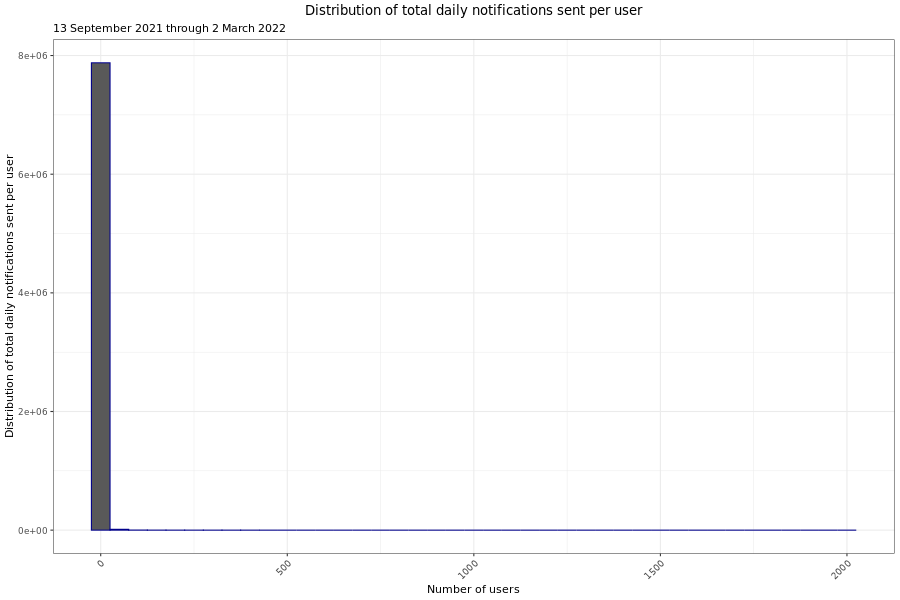

In [363]:
%%R -w 900 -h 600
# quick histogram to look at distribution of notificatons
p <- ggplot(notifications_sent_byday_total, aes(x=n_notifications)) + 
    geom_histogram(binwidth=50, color = 'darkblue') + 
        labs (y = "Distribution of total daily notifications sent per user",
          x = "Number of users",
         title = "Distribution of total daily notifications sent per user",
         subtitle = "13 September 2021 through 2 March 2022")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5))
    
p

Looking at the total number of notifications sent per user, the majority of users just receive 1 notification per day with a few outlier cases. There are 49 users that recieve more than 1000 notifications a day (less than 0.01% of all users that receive a notification).

## [Both] Percent of contributors that receive notifications and turn them off (read: change their preferences).

**Data Source**: Need to combine echo_notification database with user_properties table.

Note: 
* We are unable to review only notifications sent by the topic notifications feature. Instead, we  limited the analysis to notifications sent to users that subscribed to a topic. 
* We only instances where the contributors both received and read the notification.


### Find users that turned off the manual topic subscription property.

Notes: The manual topic subscription preference is not recorded when the user opts into the beta preference as it is enabled by default. It only shows when disabled.

First we find all users that have manually subscribed to a topic and recieved a notification.

In [365]:
# find all users that receive notifications and read them

query = '''
SELECT
database() AS wiki,
notification_user,
COUNT(notification_event) AS num_notifications
FROM
echo_notification
WHERE 
notification_user in ({users})
AND notification_timestamp >= 20211019000000
AND notification_read_timestamp IS NOT NULL
GROUP BY
database(),
notification_user
'''

In [366]:
# Looping through each wiki to identify topic subscribers that recieved notifications

wikis=active_subscribers['wiki'].unique()
active_subscribers_notification=list()
for wiki in wikis:
    user_ids = active_subscribers[active_subscribers['wiki'] == wiki]["topic_subscriber"]
    user_list = ','.join([str(u) for u in user_ids])
    notification_status = mariadb.run(
      query.format(users=user_list),
      wiki,
      use_x1 = True
    )
    active_subscribers_notification.append(notification_status)

subscribers_notification_status= pd.concat(active_subscribers_notification)

In [367]:
# find users that disabled the preference
query='''
 SELECT
    up_user AS topic_user,
    up_value AS topic_preference,
    database() AS wiki
FROM user_properties
    WHERE 
    up_property = "discussiontools-topicsubscription"
 '''

In [368]:
topic_subscribers = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [370]:
# replace skin field as string type for easier renaming 
topic_subscribers['topic_preference'] = topic_subscribers['topic_preference'].astype(str)


In [371]:
# rename pref values to clarify
pref_aliases = {
    "b\'0\'":"disabled",
    "b\'1\'":"enabled",
}

topic_subscribers =topic_subscribers.replace({"topic_preference": pref_aliases})

In [373]:
# join two dataframes
notification_users_disabled = subscribers_notification_status.merge(topic_subscribers, 
                                               how = "left", left_on = ["notification_user", "wiki"] , 
                                               right_on = ["topic_user", "wiki"])

In [374]:
#refill missing columns with string types to avoid type errors
notification_users_disabled['topic_user'] = notification_users_disabled['topic_user'].astype(str)
notification_users_disabled['topic_preference'] = notification_users_disabled['topic_preference'].astype(str)

In [375]:
%%R -i notification_users_disabled
# import from global environment

NULL


In [376]:
%%R
#Find percent of all users that received a notification and disabled the feature
notification_users_disabled_disabled_pct <- notification_users_disabled %>%
    summarise(notification_users = n(),
             topic_disabled = sum(topic_user != "nan"), #disabled if the feature is present
              pct_disabled = topic_disabled/notification_users * 100)

notification_users_disabled_disabled_pct

  notification_users topic_disabled pct_disabled
1               2925             15    0.5128205


0.5% of all users that subscribed to and recieved a notification explicitly disabled the manual topic subscription feature.

### Find users that turned off the automatic topic subscription property

Note: 
* The automatic topic subscription preference is only recorded when the user turns on the preference. It does not appear when it is disabled. 
* I only reviewed the time frame since the automatic topic subscription was available as a beta feature (2022 January 13)

In [392]:
# find all users that receive notifications and read them since auto topic subscription deplyoment

query = '''
SELECT
database() AS wiki,
notification_user,
COUNT(notification_event) AS num_notifications
FROM
echo_notification
WHERE 
notification_user in ({users})
AND notification_timestamp >= 20220113000000
AND notification_read_timestamp IS NOT NULL
GROUP BY
database(),
notification_user
'''

In [393]:
# Looping through each wiki to identify auto topic subscribers that recieved notifications

wikis=auto_topic_users['wiki'].unique()
auto_subscribers_notification=list()
for wiki in wikis:
    user_ids = auto_topic_users[auto_topic_users['wiki'] == wiki]["topic_subscriber"]
    user_list = ','.join([str(u) for u in user_ids])
    notification_status = mariadb.run(
      query.format(users=user_list),
      wiki,
      use_x1 = True
    )
    auto_subscribers_notification.append(notification_status)

auto_subscribers_notification_status= pd.concat(auto_subscribers_notification)

In [394]:
#Querying the user_properties table to find past auto subscribers that have the feature still in their preferences

query='''
 SELECT
    DISTINCT up_user AS auto_user,
    up_value AS auto_status,
    database() AS wiki
FROM user_properties
    WHERE 
    up_property = 'discussiontools-autotopicsub'   
 '''

In [395]:
auto_topic_subscribers = mariadb.run(commands = query, dbs = wiki_list, use_x1=False, format="pandas")

In [397]:
# replace skin field as string type for easier renaming 
auto_topic_subscribers['auto_status'] = auto_topic_subscribers['auto_status'].astype(str)


In [398]:
# rename pref values to clarify
pref_aliases = {
    "b\'0\'":"disabled",
    "b\'1\'":"enabled",
}

auto_topic_subscribers =auto_topic_subscribers.replace({"auto_status": pref_aliases})

In [400]:
# join two dataframes
auto_notification_users_disabled = auto_subscribers_notification_status.merge(auto_topic_subscribers, 
                                               how = "left", left_on = ["notification_user", "wiki"] , 
                                               right_on = ["auto_user", "wiki"])

In [402]:
#refill missing columns with string types to avoid type errors
auto_notification_users_disabled['auto_user'] = auto_notification_users_disabled['auto_user'].astype(str)
auto_notification_users_disabled['auto_status'] = auto_notification_users_disabled['auto_status'].astype(str)

In [403]:
%%R -i auto_notification_users_disabled
# import from global environment

NULL


In [404]:
%%R
#Find percent of all users that received a notification and disabled the feature
auto_notification_users_disabled_pct <- auto_notification_users_disabled %>%
    summarise(notification_users = n(),
             auto_disabled = sum(auto_user == "nan"), # diabled if the feature is not present
              pct_disabled = auto_disabled/notification_users * 100)

auto_notification_users_disabled_pct

  notification_users auto_disabled pct_disabled
1                207            38     18.35749


18% of automatic topic notification users that received and read a notification disabled the topic preference in their preferences.